In [1]:
%load_ext tensorboard
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime


%tensorboard --logdir logs/scalars/


tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir= "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S"),
    histogram_freq=0,
    write_graph=True,
    write_grads=True
    )

checkpoint_path = "./training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')


n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 120     # Size of the test dataset
n_batches = 4     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()



# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

tf.config.get_visible_devices()


2024-05-13 01:46:44.601412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 01:46:44.601459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 01:46:44.602515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 01:46:44.608535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 01:46:45.324951: W tensorflow/comp

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4

dev = qml.device("default.qubit.tf", wires=n_qubits)
# Random circuit parameters
random_weights = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))

@qml.qnode(dev, interface='tf')
def qnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Random quantum circuit
    RandomLayers(random_weights, wires=list(range(n_qubits)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


@qml.qnode(dev, interface='tf')
def qnotnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Filter from arxiv.org/abs/2308.14930

    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])


    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

@qml.qnode(dev, interface='tf')
def qhadrandnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')


    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[2])
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=2)(wires=0)
    qml.ctrl(qml.Hadamard, control=1)(wires=2)
    qml.ctrl(qml.Hadamard, control=0)(wires=3)
    qml.Hadamard(wires=[1])
    qml.Hadamard(wires=[0])
    qml.Hadamard(wires=[3])

    
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


2024-05-13 01:46:49.315392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [3]:
class ConvQLayer(qml.qnn.KerasLayer):
    
    @tf.function(input_signature=(tf.TensorSpec(shape=[n_qubits, 3], dtype=tf.int64), tf.TensorSpec(shape=[28,28,1], dtype=tf.float32),))
    def ops(self, op, subject):      
      qnode_inputs = []
      qnode_inputs = tf.gather_nd(subject,op)
      return tf.dtypes.cast(super().call(qnode_inputs), tf.float32)


    @tf.function(input_signature=(tf.TensorSpec(shape=[28, 28, 1], dtype=tf.float32),))
    def squares(self, inputs):
      return tf.reshape(
        tf.map_fn(lambda x: self.ops(x, inputs), 
                        self.operations,
                        parallel_iterations=196,
                        fn_output_signature=tf.TensorSpec(shape=[n_qubits,], dtype=tf.float32)
                        ),
          [14,14,n_qubits])

    @tf.function(input_signature=(tf.TensorSpec(shape=[n_batches,28,28,1], dtype=tf.float32),))
    def batches(self, data):
      return tf.map_fn(lambda x: self.squares(x), 
                      data,
                        parallel_iterations=n_batches,
                        fn_output_signature=tf.TensorSpec(shape=[14,14, n_qubits], dtype=tf.float32)
                        )

    def call(self, inputs):
      operation = []
      for j in range(0, 28, 2):
          for k in range(0, 28, 2):
              operation.append(
                  [
                      [j, k, 0],
                      [j, k + 1, 0],
                      [j + 1, k, 0],
                      [j + 1, k + 1, 0]
                  ]
              )
      self.operations = tf.convert_to_tensor(np.asarray(operation))
      return self.batches(inputs)

qlayer = ConvQLayer(qhadrandnode, {}, output_dim=[14,14,n_qubits])

qlayer.trainable = False

In [4]:
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        qlayer
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

In [5]:


def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

train_images = pre_model.predict(train_images,batch_size=n_batches)
test_images = pre_model.predict(test_images,batch_size=n_batches)
q_model = Q_Model()

q_history = q_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2, callbacks=[tensorboard_callback, cp_callback],
    shuffle=True
)



Cause: Unable to locate the source code of <function _gcd_import at 0x7db9a170fd80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function _gcd_import at 0x7db9a170fd80>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @t

2024-05-13 01:50:15.844463: I external/local_xla/xla/service/service.cc:168] XLA service 0x7db7fbb87070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-13 01:50:15.844509: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-13 01:50:15.849517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-13 01:50:15.863526: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715565015.981345    7256 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: saving model to ./training_2/cp-0001.ckpt
50/50 - 1s - loss: 2.2888 - accuracy: 0.1750 - val_loss: 2.1185 - val_accuracy: 0.3167 - 954ms/epoch - 19ms/step
Epoch 2/30

Epoch 2: saving model to ./training_2/cp-0002.ckpt
50/50 - 0s - loss: 1.7233 - accuracy: 0.5400 - val_loss: 1.7567 - val_accuracy: 0.5000 - 241ms/epoch - 5ms/step
Epoch 3/30

Epoch 3: saving model to ./training_2/cp-0003.ckpt
50/50 - 0s - loss: 1.3157 - accuracy: 0.7750 - val_loss: 1.5780 - val_accuracy: 0.5167 - 283ms/epoch - 6ms/step
Epoch 4/30

Epoch 4: saving model to ./training_2/cp-0004.ckpt
50/50 - 0s - loss: 1.0368 - accuracy: 0.8500 - val_loss: 1.4164 - val_accuracy: 0.6250 - 296ms/epoch - 6ms/step
Epoch 5/30

Epoch 5: saving model to ./training_2/cp-0005.ckpt
50/50 - 0s - loss: 0.8671 - accuracy: 0.8400 - val_loss: 1.3305 - val_accuracy: 0.6250 - 265ms/epoch - 5ms/step
Epoch 6/30

Epoch 6: saving model to ./training_2/cp-0006.ckpt
50/50 - 0s - loss: 0.7022 - accuracy: 0.9350 - val_loss: 1.2509 - val_ac

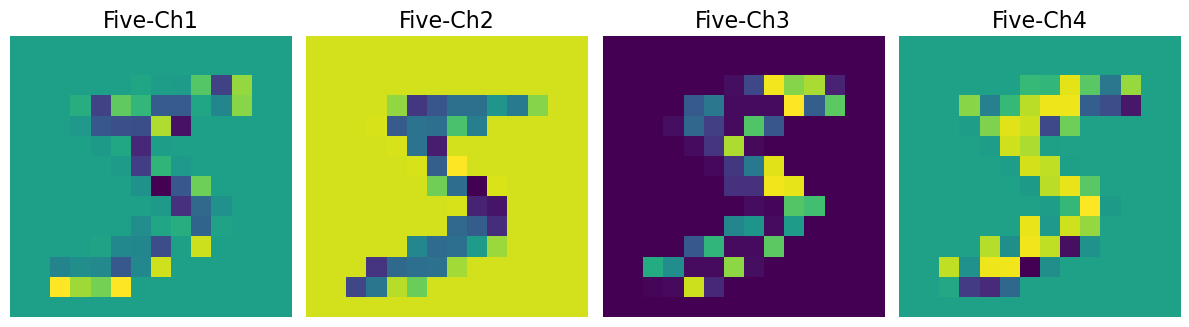

In [6]:
image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(train_images[0][:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()